In [1]:
import numpy as np # type: ignore
import pandas as pd # type: ignore

from pathlib import Path
import matplotlib.pyplot as plt # type: ignore

import acoular as ac # type: ignore
import sounddevice as sd # type: ignore
from acoupipe.datasets.synthetic import DatasetSynthetic # type: ignore
from acoupipe.datasets.synthetic import DatasetSyntheticConfig # type: ignore
import acoupipe.sampler as sp # type: ignore
from traits.api import Dict # type: ignore
from scipy.stats import uniform # type: ignore

/home/rabea/micromamba/envs/ba/lib/python3.11/site-packages/acoular/h5files.py:5: UserWarning: We detected that Numpy is already loaded and uses OpenBLAS. Because this conflicts with Numba parallel execution, we disable parallel execution for now and processing might be slower. To speed up, either import Numpy after Acoular or set environment variable OPENBLAS_NUM_THREADS=1 before start of the program.
  from .configuration import config
2024-08-18 13:12:01.179509: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 13:12:01.179536: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 13:12:01.201892: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attemptin

In [2]:
YMIN_MEASUREMENT = -1.5
YMAX_MEASUREMENT = 1.5
XMIN_MEASUREMENT = -1.5
XMAX_MEASUREMENT = 1.5
Z = 2.0
INCREMENT = 3/63
MAXNSOURCES = 9

In [3]:
class ConfigUMA(DatasetSyntheticConfig):
    """Configuration for the UMA-16 microphone array.

    Based on an example from the acoupipe documentation.
    https://adku1173.github.io/acoupipe/contents/jupyter/modify.html
    """
    fft_params = Dict({
                    'block_size' : 256,
                    'overlap' : '50%',
                    'window' : 'Hanning',
                    'precision' : 'complex64'},
                desc='FFT parameters')

    def create_mics(self):
        """Create the microphone array.
        """
        uma_file = Path(ac.__file__).parent / 'xml' / 'minidsp_uma-16.xml'
        return ac.MicGeom(from_file=uma_file)

    def create_grid(self):
        """Create a grid for the sources.
        """
        return ac.RectGrid(y_min=YMIN_MEASUREMENT, y_max=YMAX_MEASUREMENT, x_min=XMIN_MEASUREMENT, x_max=XMAX_MEASUREMENT, z=Z, increment=INCREMENT)

    def create_location_sampler(self):
        """Create a location sampler for the sources.
        """
        location_sampler = sp.LocationSampler(
            random_var = (uniform(-1.5,3),uniform(-1.5,3),uniform(2.0,0)),
            nsources = MAXNSOURCES,
            ) 
        
        # Default:
        # location_sampler = sp.LocationSampler(
        #     random_var = (norm(0,0.1688*ap),norm(0,0.1688*ap),norm(z,0)), #2d also passt z so
        #     x_bounds = (-0.5*ap,0.5*ap),
        #     y_bounds = (-0.5*ap,0.5*ap),
        #     z_bounds = (0.5*ap,0.5*ap),
        #     nsources = self.max_nsources,
        #     mindist = 0.1*ap,)
        
        if self.snap_to_grid:
            location_sampler.grid = self.source_grid
        
        return location_sampler
    
    def mic_positions(self, shifted=True):
        """Get the positions of the microphones.
        """
        # TODO Welches Mikro nehmen wir als Referenz? Hier Mikro obere linke Ecke
        if shifted:
            return self.mics.mpos + np.array([[0.063, -0.063, 0]]).T
        
        return self.mics.mpos
    
        # mic_positions:
        # [[ 0.021  0.063  0.021  0.063  0.021  0.063  0.021  0.063 -0.063 -0.021 -0.063 -0.021 -0.063 -0.021 -0.063 -0.021]
        #  [-0.063 -0.063 -0.021 -0.021  0.021  0.021  0.063  0.063  0.063  0.063  0.021  0.021 -0.021 -0.021 -0.063 -0.063]
        #  [ 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]]

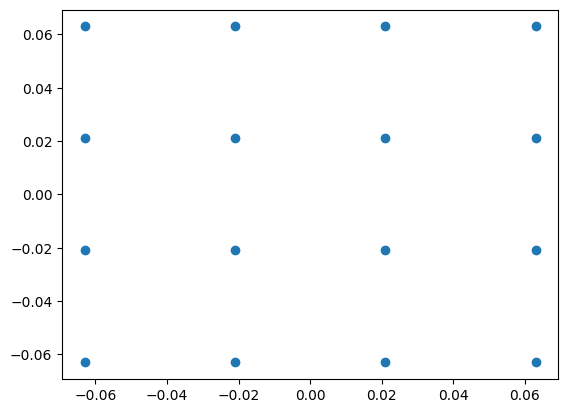

In [4]:
# Uma16 microphone array
config = ConfigUMA() 

dataset_uma = DatasetSynthetic(config=config)

plt.figure()
plt.scatter(
    dataset_uma.config.mics.mpos[0],
    dataset_uma.config.mics.mpos[1])
plt.show()


/home/rabea/micromamba/envs/ba/lib/python3.11/site-packages/acoupipe/datasets/features.py:140: Warning: Queried frequency (4000 Hz) not in set of discrete FFT sample frequencies. Using frequency 4019.53 Hz instead.
  fidx = [get_frequency_index_range(
/home/rabea/micromamba/envs/ba/lib/python3.11/site-packages/traits/has_traits.py:1691: Warning: Deprecated use of 'mpos' trait. 
  setattr(self, name, value)
/home/rabea/micromamba/envs/ba/lib/python3.11/site-packages/traits/has_traits.py:1691: Warning: Deprecated use of 'c' trait. 
  setattr(self, name, value)
/home/rabea/micromamba/envs/ba/lib/python3.11/site-packages/acoupipe/datasets/features.py:161: Warning: Queried frequency (4000 Hz) not in set of discrete FFT sample frequencies. Using frequency 4019.53 Hz instead.
  sm = array([beamformer.synthetic(freq,num=num) for freq in f])
/tmp/ipykernel_6400/3763281532.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl

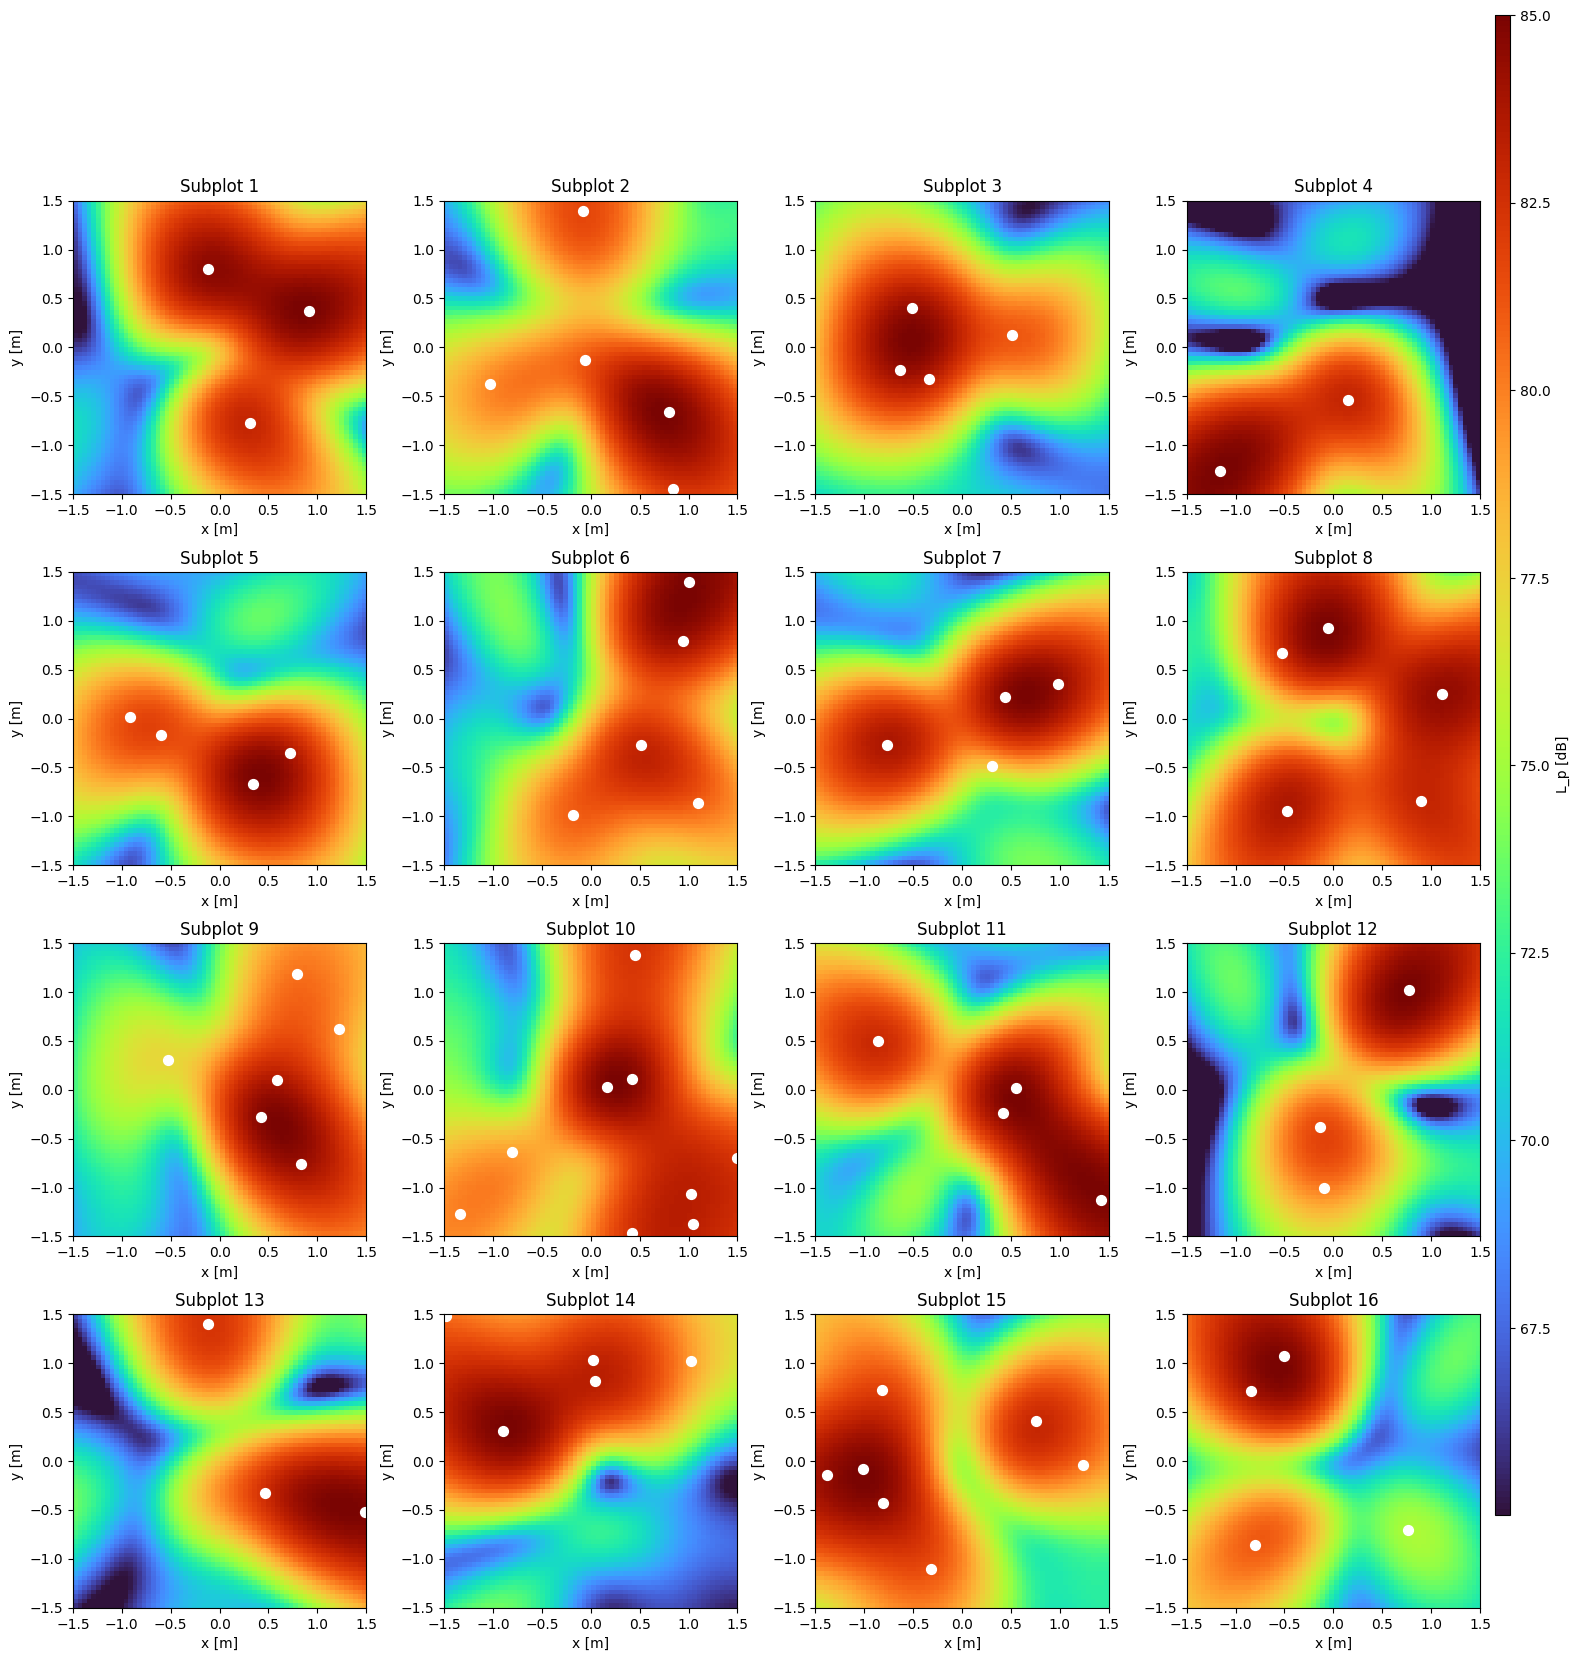

In [5]:
# Synthetische Daten

data_generator = dataset_uma.generate(
    split='training', features=['sourcemap','loc'],
    f=4000, size=1000, progress_bar=False)

fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for i in range(4):
    for j in range(4):
        data = next(data_generator)
        Lm = ac.L_p(data['sourcemap'].T)  # Konvertiere zu dB
        
        source_locations = data['loc'].T

        axs[i, j].scatter(source_locations[:, 0], source_locations[:, 1], 
                            c='white', s=50, label='Sources')

        im = axs[i, j].imshow(Lm, origin='lower', extent=dataset_uma.config.grid.extend(),
                              cmap='turbo', vmin=Lm.max()-20, vmax=Lm.max())
        axs[i, j].set_xlabel('x [m]')
        axs[i, j].set_ylabel('y [m]')
        axs[i, j].set_title(f'Subplot {i*4 + j + 1}') 

plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1, 0.1, 0.01, 1])
fig.colorbar(im, cax=cbar_ax, orientation='vertical', label='L_p [dB]')
plt.tight_layout()  
plt.show()


In [6]:
data_generator = dataset_uma.generate(
    split='training', features=['sourcemap','loc','csm'],
    f=4000, size=4, progress_bar=False)


for sample in data_generator:
    print(sample.keys())
    print(sample['sourcemap'].shape)
    print(sample['loc'].shape)
    print(sample['csm'].shape)
    print(sample['csm'])
    break
    

/home/rabea/micromamba/envs/ba/lib/python3.11/site-packages/acoupipe/datasets/features.py:210: Warning: Queried frequency (4000 Hz) not in set of discrete FFT sample frequencies. Using frequency 4019.53 Hz instead.
  fidx = [get_frequency_index_range(


dict_keys(['idx', 'seeds', 'csm', 'sourcemap', 'loc'])
(1, 64, 64)
(3, 3)
(1, 16, 16)
[[[ 0.18966393+6.94223637e-11j  0.13189305-6.00109994e-02j
    0.10337508-5.70767000e-02j  0.05240756-9.61985663e-02j
   -0.0436253 -7.70629942e-02j -0.08910763-7.78238028e-02j
   -0.10173915-6.13459796e-02j -0.18061575-1.31545821e-02j
   -0.03842947+5.86697198e-02j -0.02588633-1.68257914e-02j
   -0.09344156+3.53899039e-02j -0.02027797-1.16617465e-02j
   -0.04809389+3.44870649e-02j  0.07280777+2.37455200e-02j
    0.0230798 +4.96129505e-02j  0.11953701+8.26139823e-02j]
  [ 0.13189305+6.00109994e-02j  0.19127443+8.80848432e-12j
    0.06182227+2.25507449e-02j  0.09727854-6.64476231e-02j
   -0.02407009+6.69308996e-04j -0.03365346-7.72198290e-02j
   -0.02002737-6.26630150e-03j -0.10785352-5.62608987e-02j
   -0.09354995+7.04493448e-02j -0.02953885+6.95055127e-02j
   -0.16612113+6.58934377e-03j -0.08289126+5.70449010e-02j
   -0.11707363-4.28199656e-02j -0.03736826+4.52697352e-02j
    0.00483088-4.35997024e-0